In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler



from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

from sklearn.metrics import roc_auc_score, roc_curve, auc

####################################################
# Load the data
df = pd.read_csv("n/full_data_flightdelay.csv.xz", compression='xz')
# df = pd.read_csv("test.csv.xz", compression='xz')
#print(df.head())

# take a random sample of 1000 rows
df = df.sample(n=10000, random_state=42)

ontime = df[df['DEP_DEL15'] == 0]
delayed = df[df['DEP_DEL15'] == 1]

In [3]:
# DATA CLEANING
# encode the categorical data
le = LabelEncoder()

def clean_labels_encoder(list_of_labels, df):
    for label in list_of_labels:
        df[label] = le.fit_transform(df[label])
    return df

# clean the labels
list_of_labels = ['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DEP_TIME_BLK']
df = clean_labels_encoder(list_of_labels, df)

# Drop the columns that are not needed
# df = df.drop(['CARRIER_HISTORICAL', 'DEP_AIRPORT_HIST', 'DAY_HISTORICAL',
#        'DEP_BLOCK_HIST'], axis=1)

# Fill the missing values
df.fillna(df.mean(), inplace=True)

Standard Scaler
Random Forest
0.799
Cross Validation value is  0.7945
[[1588    7]
 [ 395   10]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1595
           1       0.59      0.02      0.05       405

    accuracy                           0.80      2000
   macro avg       0.69      0.51      0.47      2000
weighted avg       0.76      0.80      0.72      2000

0.5101513216455746
KNN
0.7815
Cross Validation value is  0.767
[[1511   84]
 [ 353   52]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1595
           1       0.38      0.13      0.19       405

    accuracy                           0.78      2000
   macro avg       0.60      0.54      0.53      2000
weighted avg       0.72      0.78      0.74      2000

0.5378652424629436
SVM
0.6325
Cross Validation value is  0.6094999999999999
[[1036  559]
 [ 176  229]]
              precision    recall  f1-score   support

 

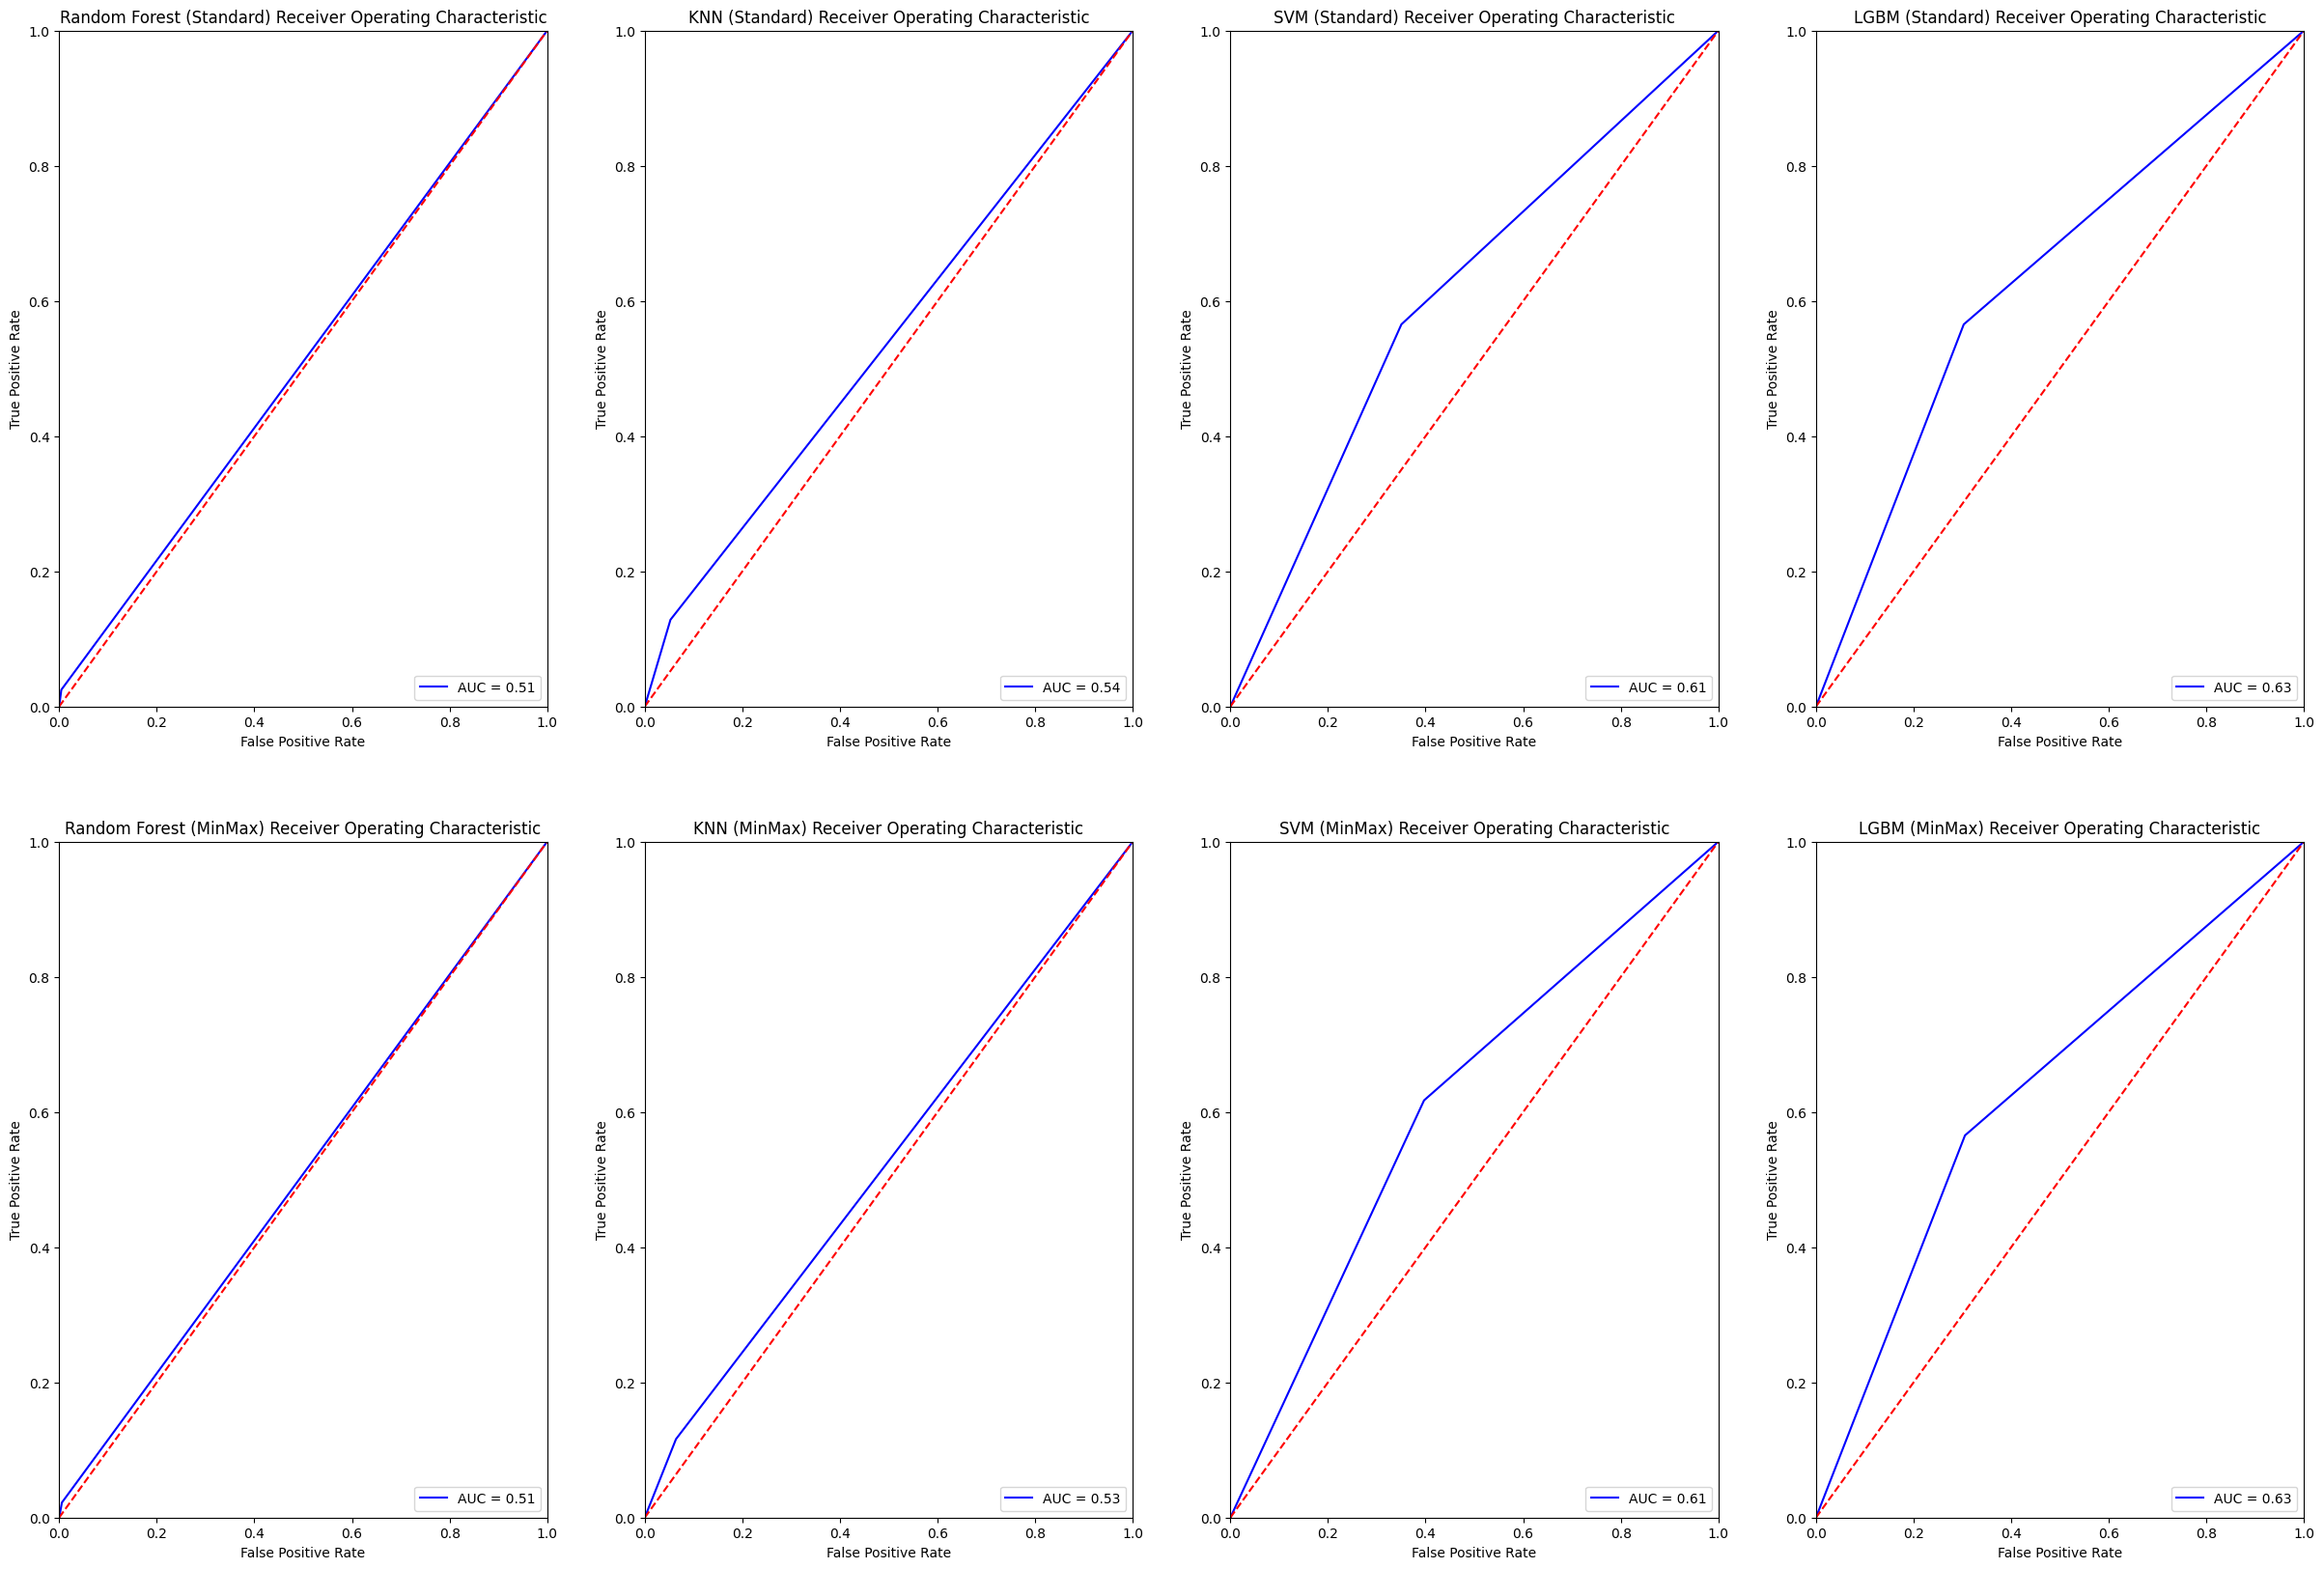

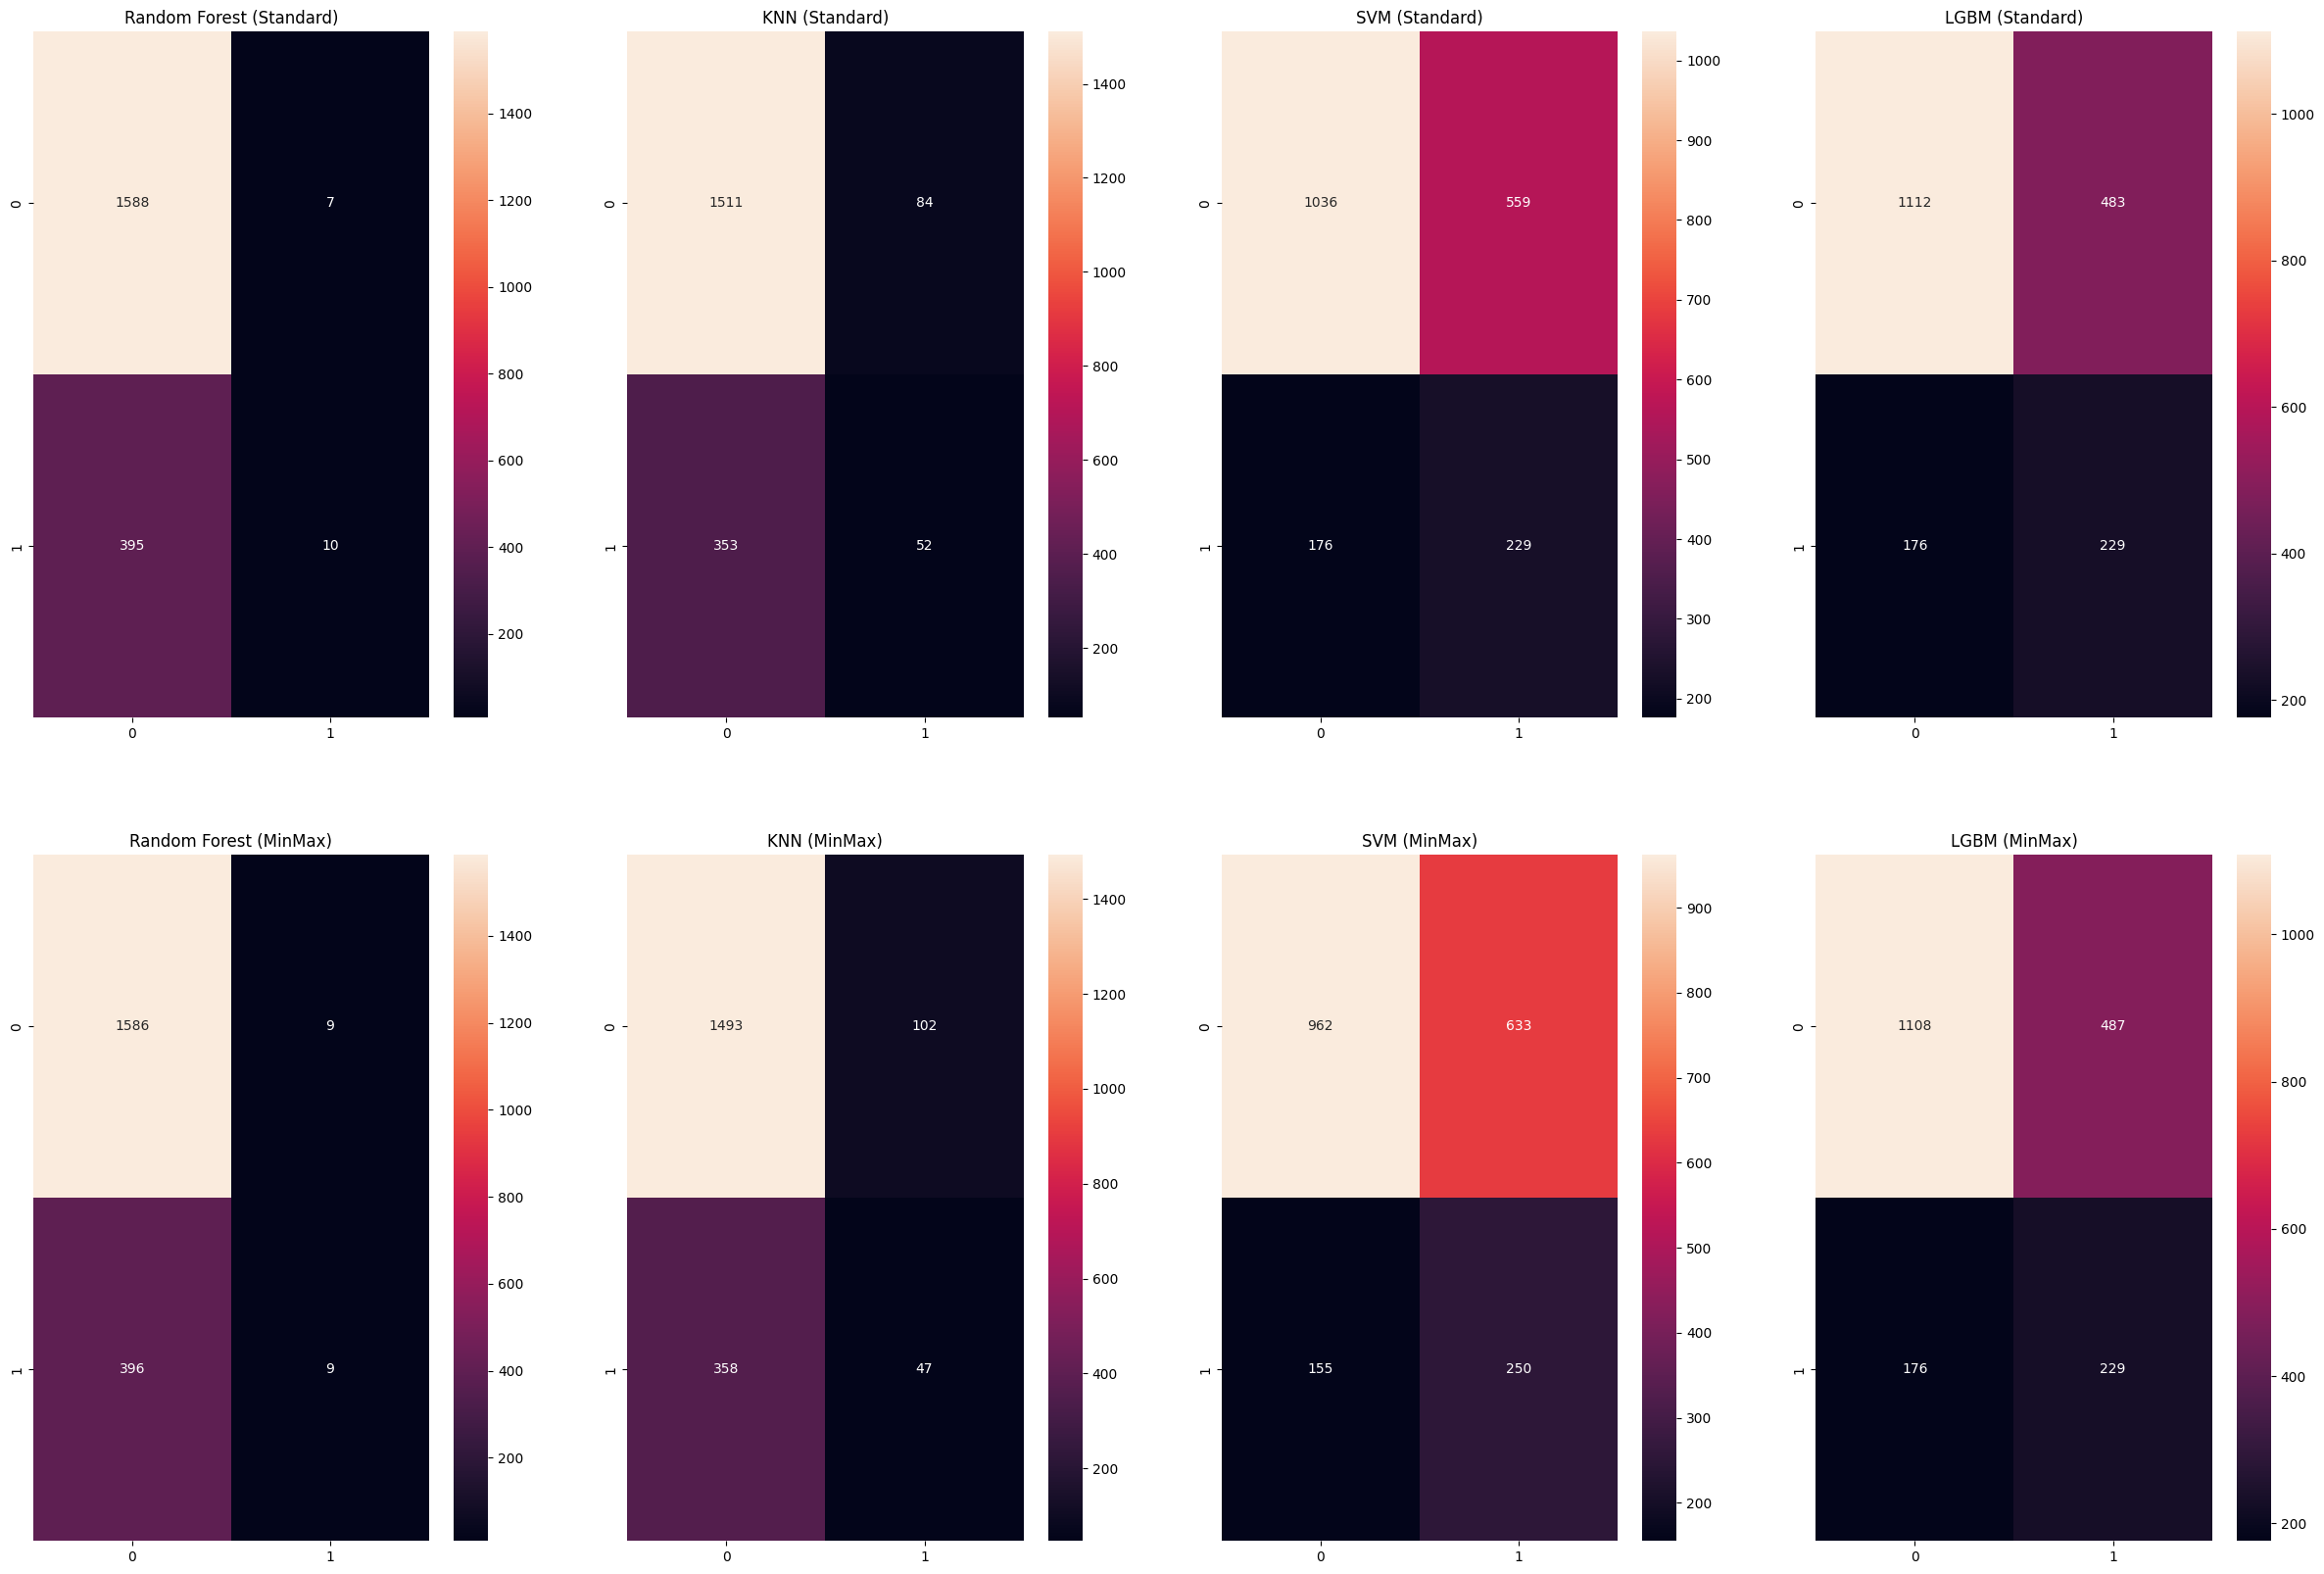

In [20]:
# Perform Random Forest, KNN, SVM, and LGBM with weighted data

def perform_classification_weighted(df):
    X = df.drop(['DEP_DEL15'], axis=1)
    y = df['DEP_DEL15']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
    classifiers = {RandomForestClassifier(class_weight={0: 1, 1: weights}): 'Random Forest', 
               KNeighborsClassifier(n_neighbors=5): 'KNN', 
               SVC(class_weight={0: 1, 1: weights}): 'SVM',
               LGBMClassifier(boosting_type='dart', verbose=-1, 
                              class_weight={0: 1, 1: weights}, 
                              random_state=42): 'LGBM'}
    accuracy_scores = []
    cross_val_scores = []
    roc_auc_scores = []
    classification_reports = []
    confusion_matrices = []
    roc_thresholds = []
    


    scalers = {StandardScaler():"Standard Scaler", MinMaxScaler(): "MinMax Scaler"}
    for scaler, name_scaler in scalers.items():
        print(name_scaler)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        for clf, name in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            print(name)
            print(accuracy_score(y_test, y_pred))
            print("Cross Validation value is ",np.mean(cross_val_score(clf ,X_test,y_test,cv=5)))
            print(confusion_matrix(y_test, y_pred))
            print(classification_report(y_test, y_pred))
            print(roc_auc_score(y_test, y_pred))
            fpr, tpr, threshold = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            accuracy_scores.append(accuracy_score(y_test, y_pred))
            cross_val_scores.append(np.mean(cross_val_score(clf ,X_test,y_test,cv=5)))
            roc_auc_scores.append(roc_auc_score(y_test, y_pred))
            classification_reports.append(classification_report(y_test, y_pred))
            confusion_matrices.append(confusion_matrix(y_test, y_pred))
            roc_thresholds.append(roc_curve(y_test, y_pred))

            #method I: plt
            # plt.title(name + ' Receiver Operating Characteristic')
            # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_test, y_pred))
            # plt.legend(loc = 'lower right')
            # plt.plot([0, 1], [0, 1],'r--')
            # plt.xlim([0, 1])
            # plt.ylim([0, 1])
            # plt.ylabel('True Positive Rate')
            # plt.xlabel('False Positive Rate')
            # plt.show()
    # Plot all the ROC curves
    models = ['Random Forest (Standard)', 'KNN (Standard)', 'SVM (Standard)', 'LGBM (Standard)',
              'Random Forest (MinMax)', 'KNN (MinMax)', 'SVM (MinMax)', 'LGBM (MinMax)']
    fig, ax = plt.subplots(2,4, figsize=(30,20))
    for i, roc in enumerate(roc_thresholds):
        fpr, tpr, threshold = roc
        roc_auc = auc(fpr, tpr)
        ax[i//4, i%4].set_title(models[i] + ' Receiver Operating Characteristic')
        ax[i//4, i%4].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        ax[i//4, i%4].legend(loc = 'lower right')
        ax[i//4, i%4].plot([0, 1], [0, 1],'r--')
        ax[i//4, i%4].set_xlim([0, 1])
        ax[i//4, i%4].set_ylim([0, 1])
        ax[i//4, i%4].set_ylabel('True Positive Rate')
        ax[i//4, i%4].set_xlabel('False Positive Rate')
    plt.show()

    # Plot the confusion matrices
    fig, ax = plt.subplots(2,4, figsize=(30,20))
    for i, cm in enumerate(confusion_matrices):
        ax[i//4, i%4].set_title(models[i])
        sns.heatmap(cm, annot=True, fmt='g', ax=ax[i//4, i%4])
    plt.show()



    return 
    

perform_classification_weighted(df)

# print(accuracy_scores)
# print(cross_val_scores)
# print(roc_auc_scores)
# print(classification_reports)
# print(confusion_matrices)




Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
RFECV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
      scoring='neg_mean_squared_error', verbose=1)
Optimal number of features 21
[12 13 21 22]
Index(['AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'SNOW', 'SNWD'], dtype='object')
Random Forest
0.796
Cross Validation value is  0.7909999999999999
[[1579   16]
 [ 392   13]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1595
           1       0.45      0.03      0.06       405

    accuracy                           0.80      2000
   macro avg       0.62      0.51      0.47      2000
weighted avg       0.73      0.80      0.72      2000

0.5110337087348582
KNN
0.772
Cross Validation value is  0.7649999999999999
[[1496   99]
 [ 357   48]]
              precision    recall  f1-score   support

           0       0.81      0

C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: U

Cross Validation value is  0.7345
[[1209  386]
 [ 211  194]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1595
           1       0.33      0.48      0.39       405

    accuracy                           0.70      2000
   macro avg       0.59      0.62      0.60      2000
weighted avg       0.75      0.70      0.72      2000

0.6185030380432679


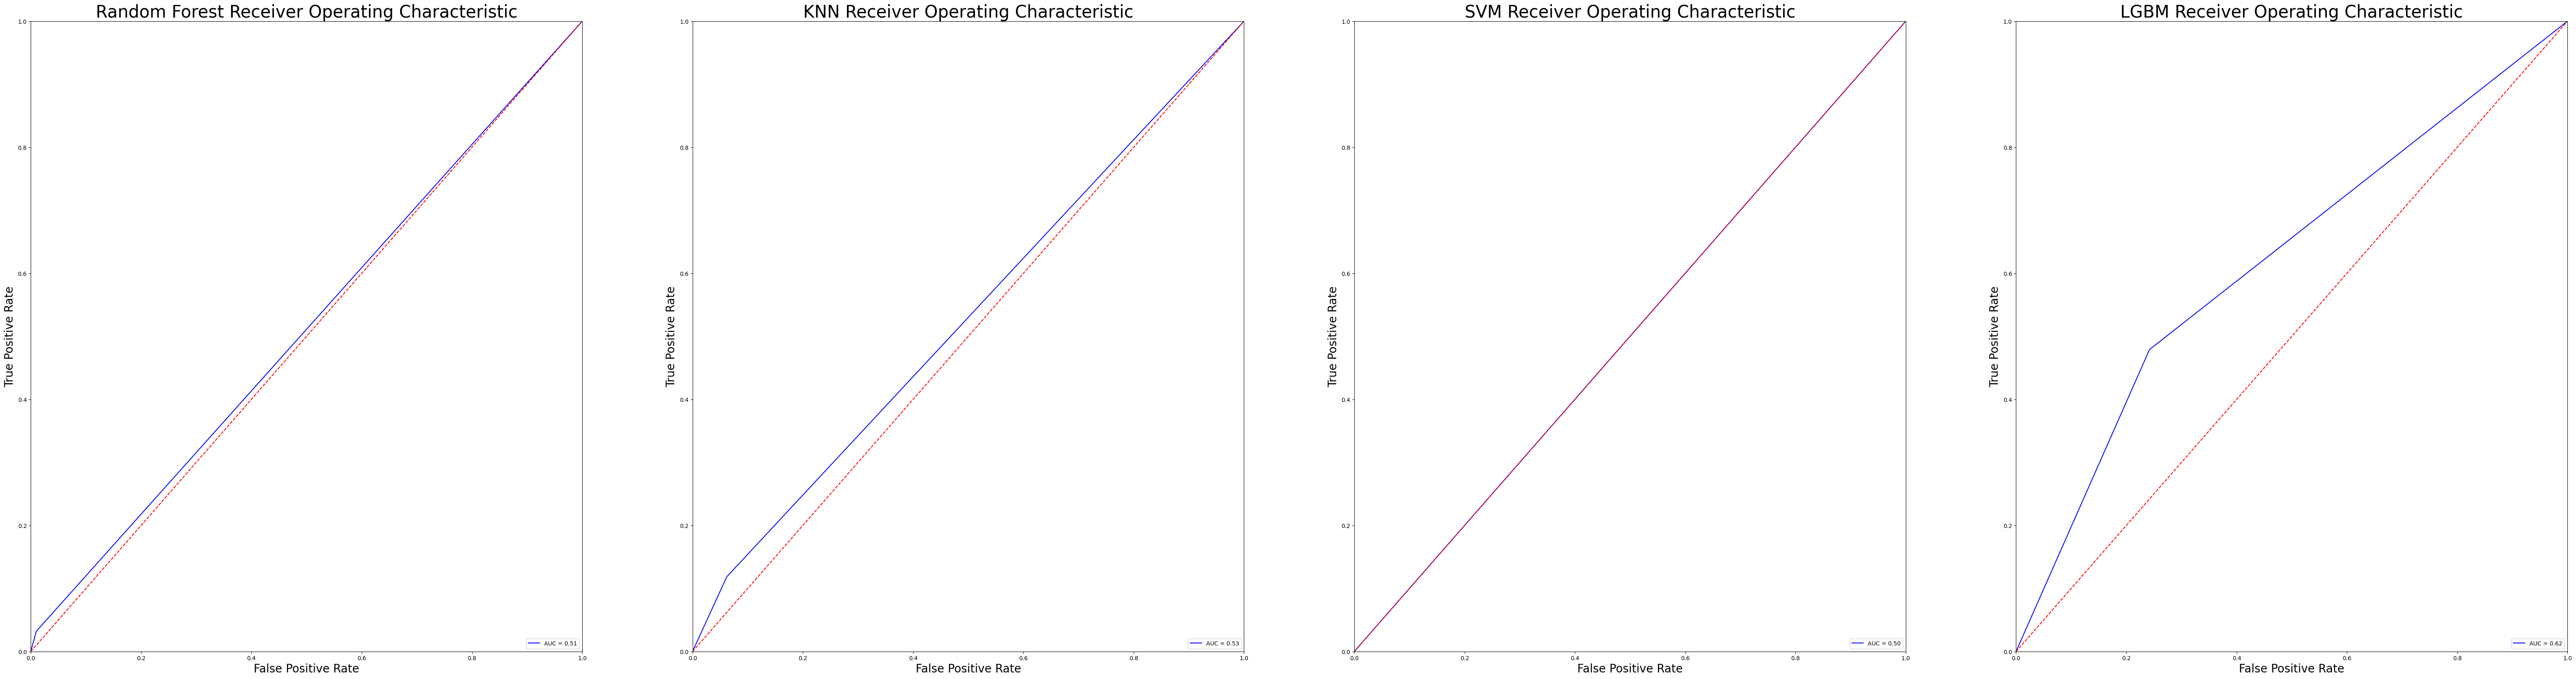

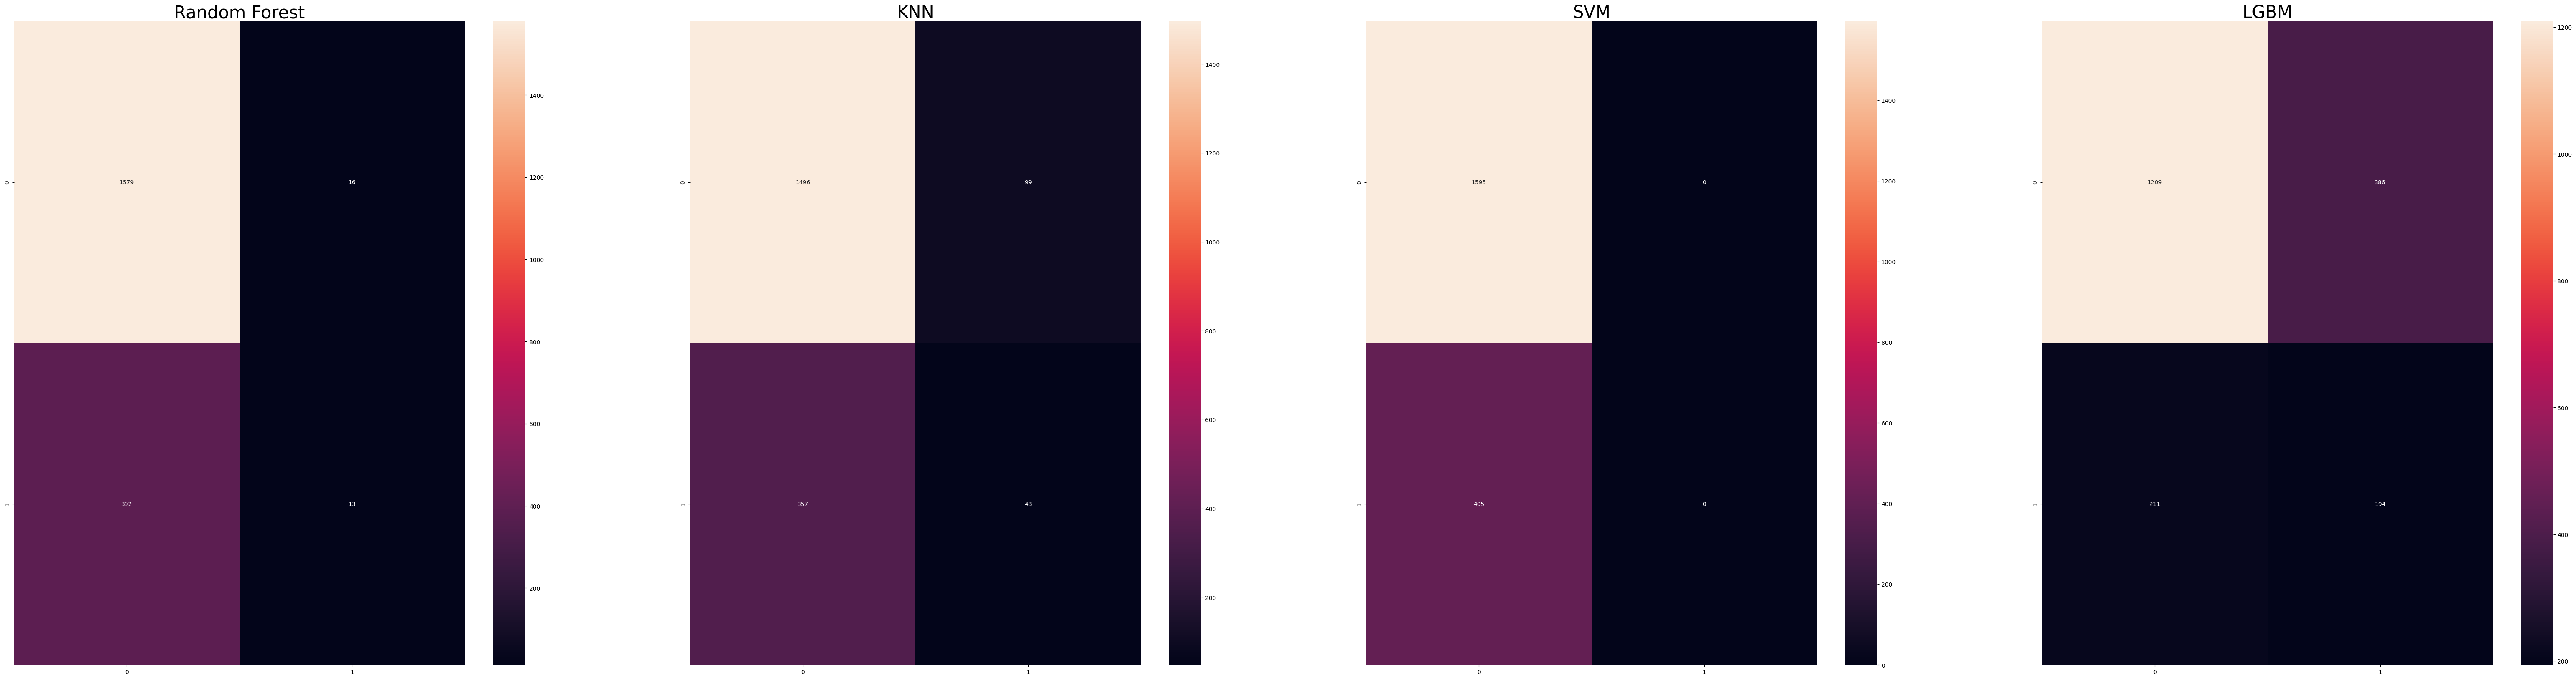

In [21]:
# Perform Recursive Feature Elimination

from sklearn.ensemble import RandomForestClassifier


def perform_rfe(df):
    X = df.drop(['DEP_DEL15'], axis=1)
    y = df['DEP_DEL15']


    clf = RandomForestClassifier()
    selector = RFECV(clf, step=1, scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=-1)
    selector.fit(X, y)
    selector.transform(X)
    print(selector)
    print("Optimal number of features {}".format(selector.n_features_))
    print(np.where(selector.support_ == False)[0])
    print(X.columns[selector.support_ == False])
    X.drop(X.columns[selector.support_ == False], axis=1, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
    classifiers = {RandomForestClassifier(): 'Random Forest', 
               KNeighborsClassifier(n_neighbors=5): 'KNN', 
               SVC(): 'SVM',
               LGBMClassifier(verbose=-1, class_weight={0: 1, 1: weights}): 'LGBM'}
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    roc_thresholds = []
    confusion_matrices = []


    for clf, name in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(accuracy_score(y_test, y_pred))
        print("Cross Validation value is ",np.mean(cross_val_score(clf ,X_test,y_test,cv=5)))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(roc_auc_score(y_test, y_pred))
        # fpr, tpr, threshold = roc_curve(y_test, y_pred)
        # roc_auc = auc(fpr, tpr)

        roc_thresholds.append(roc_curve(y_test, y_pred))
        confusion_matrices.append(confusion_matrix(y_test, y_pred))

        # method I: plt
        # plt.title(name + ' Receiver Operating Characteristic')
        # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        # plt.legend(loc = 'lower right')
        # plt.plot([0, 1], [0, 1],'r--')
        # plt.xlim([0, 1])
        # plt.ylim([0, 1])
        # plt.ylabel('True Positive Rate')
        # plt.xlabel('False Positive Rate')
        # plt.show()
    
    # Plot all the ROC curves
    models = ['Random Forest', 'KNN', 'SVM', 'LGBM']
    fig, ax = plt.subplots(1,4, figsize=(80,20))
    for i, roc in enumerate(roc_thresholds):
        fpr, tpr, threshold = roc
        roc_auc = auc(fpr, tpr)
        ax[i].set_title(models[i] + ' Receiver Operating Characteristic', fontsize=30)
        ax[i].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        ax[i].legend(loc = 'lower right')
        ax[i].plot([0, 1], [0, 1],'r--')
        ax[i].set_xlim([0, 1])
        ax[i].set_ylim([0, 1])
        ax[i].set_ylabel('True Positive Rate', fontsize=20)
        ax[i].set_xlabel('False Positive Rate', fontsize=20)
    plt.show()
    sns.reset_orig()
    # Plot the confusion matrices
    fig, ax = plt.subplots(1,4, figsize=(80,20))
    for i, cm in enumerate(confusion_matrices):
        ax[i].set_title(models[i], fontsize=30)
        sns.heatmap(cm, annot=True, fmt='g', ax=ax[i])

perform_rfe(df)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'lambda_l1': 1.5, 'lambda_l2': 1, 'min_data_in_leaf': 400, 'num_leaves': 31, 'reg_alpha': 0.1}
0.6069473909782492
0.6375
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Cross Validation value is  0.6567901234567901
[[1017  578]
 [ 147  258]]
              precision    recall  f1-score   support

           0       0.87      0.64      0.74      1595
           1       0.31      0.64      0.42       405

    accuracy                           0.64      2000
   macro avg       0.59      0.64      0.58      2000
weighted avg       0.76      0.64      0.67      2000

0.6373272959479857


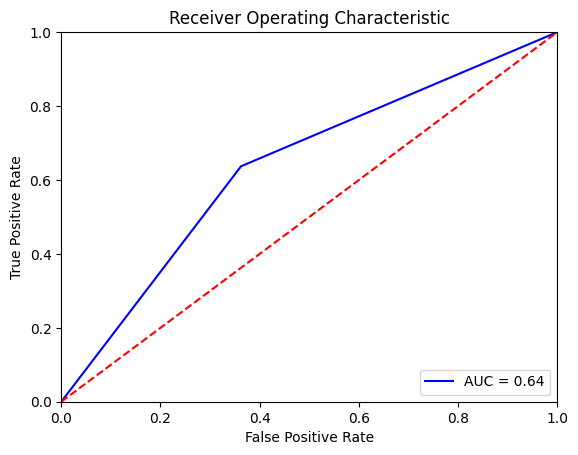

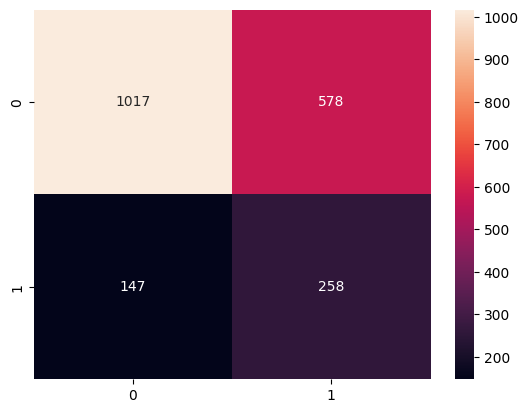

In [27]:
# Perform Hyperparameter tuning on the LGBM model


def perform_hyperparameter_tuning(df):
    X = df.drop(['DEP_DEL15'], axis=1)
    y = df['DEP_DEL15']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
    lgbm = LGBMClassifier(boosting_type='dart', verbose=-1, 
                          class_weight={0: 1, 1: weights}, 
                          random_state=42)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    param_grid = {
        'num_leaves': [31, 127],
        'reg_alpha': [0.1, 0.5],
        'min_data_in_leaf': [30, 50, 100, 300, 400],
        'lambda_l1': [0, 1, 1.5],
        'lambda_l2': [0, 1],
        
    }
    grid_search = GridSearchCV(lgbm, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='recall')
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    y_pred = grid_search.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    print("Cross Validation value is ",np.mean(cross_val_score(grid_search ,X_test,y_test,cv=5)))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(roc_auc_score(y_test, y_pred))
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    sns.reset_orig()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # Plot the confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    plt.show()

    return 

perform_hyperparameter_tuning(df)



C:\Users\Fraser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Standard Scaler
Random Forest
0.8304597701149425
Cross Validation value is  0.8293103448275863
[[1440    9]
 [ 286    5]]
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91      1449
         1.0       0.36      0.02      0.03       291

    accuracy                           0.83      1740
   macro avg       0.60      0.51      0.47      1740
weighted avg       0.75      0.83      0.76      1740

0.5054854752299844
KNN
0.8086206896551724
Cross Validation value is  0.8126436781609195
[[1383   66]
 [ 267   24]]
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      1449
         1.0       0.27      0.08      0.13       291

    accuracy                           0.81      1740
   macro avg       0.55      0.52      0.51      1740
weighted avg       0.74      0.81      0.76      1740

0.5184627862799086
SVM
0.6436781609195402
Cross Validation value is  0.6706896551724137
[[951 498]
 [122 169]

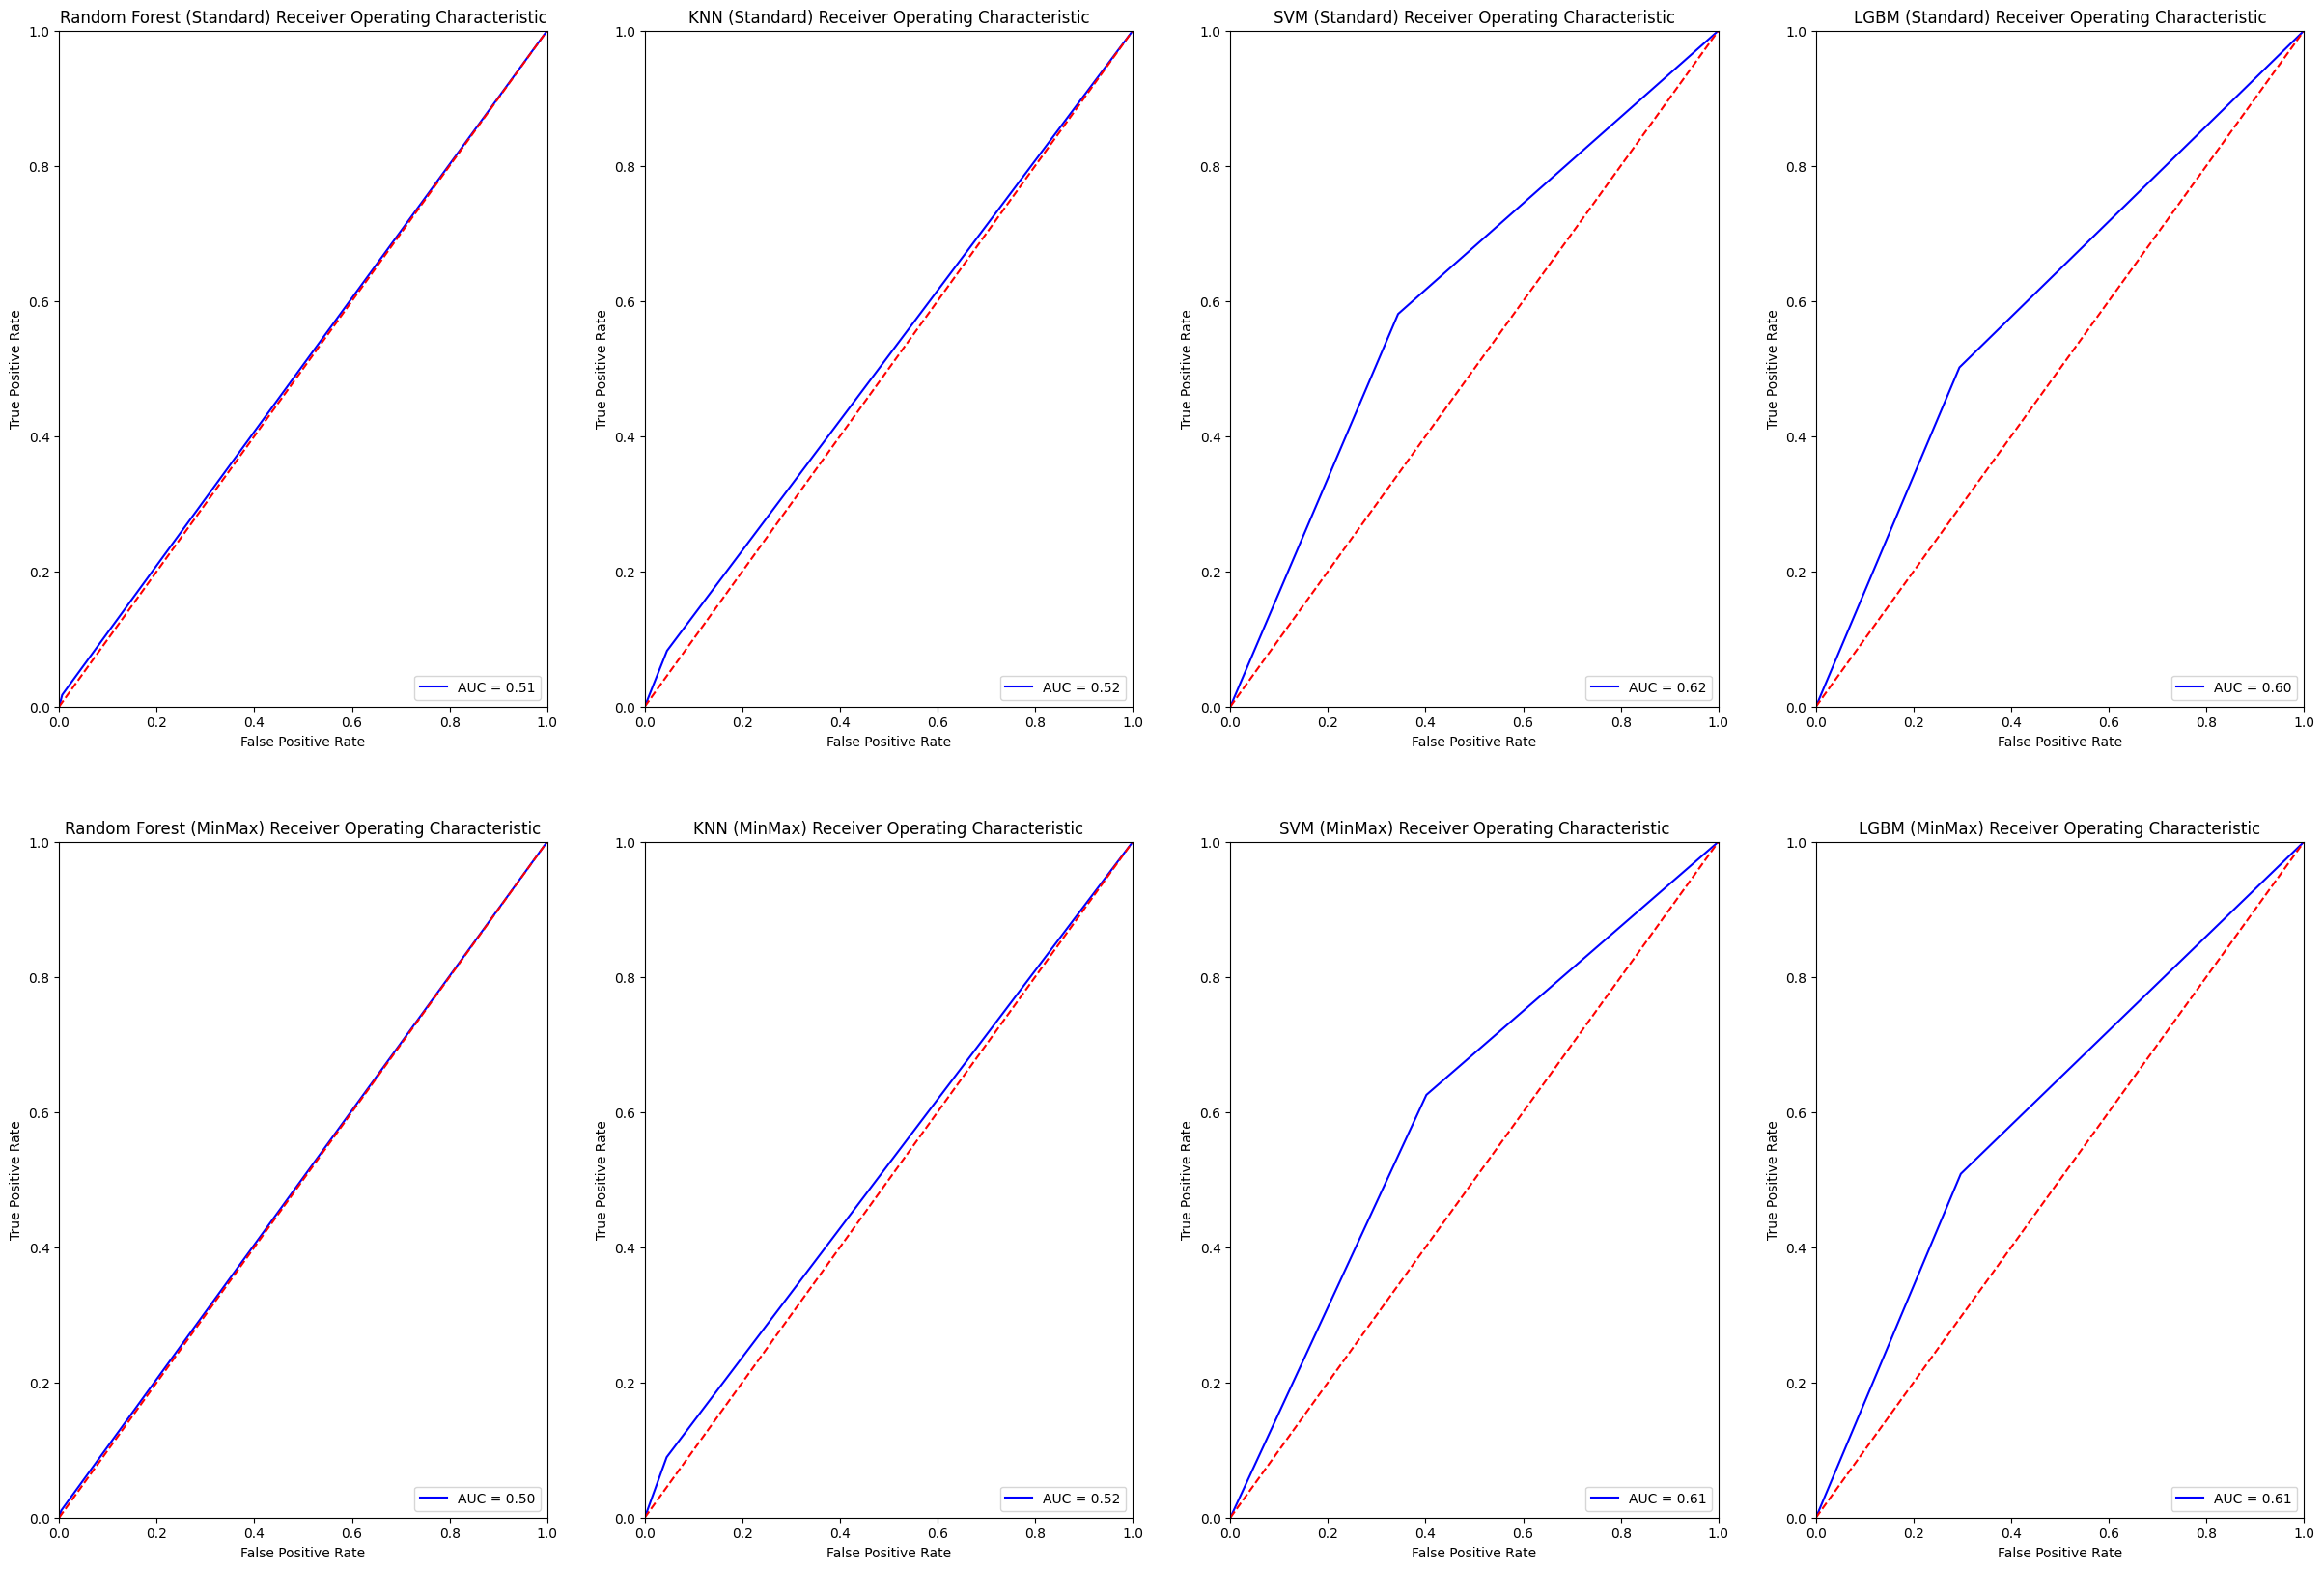

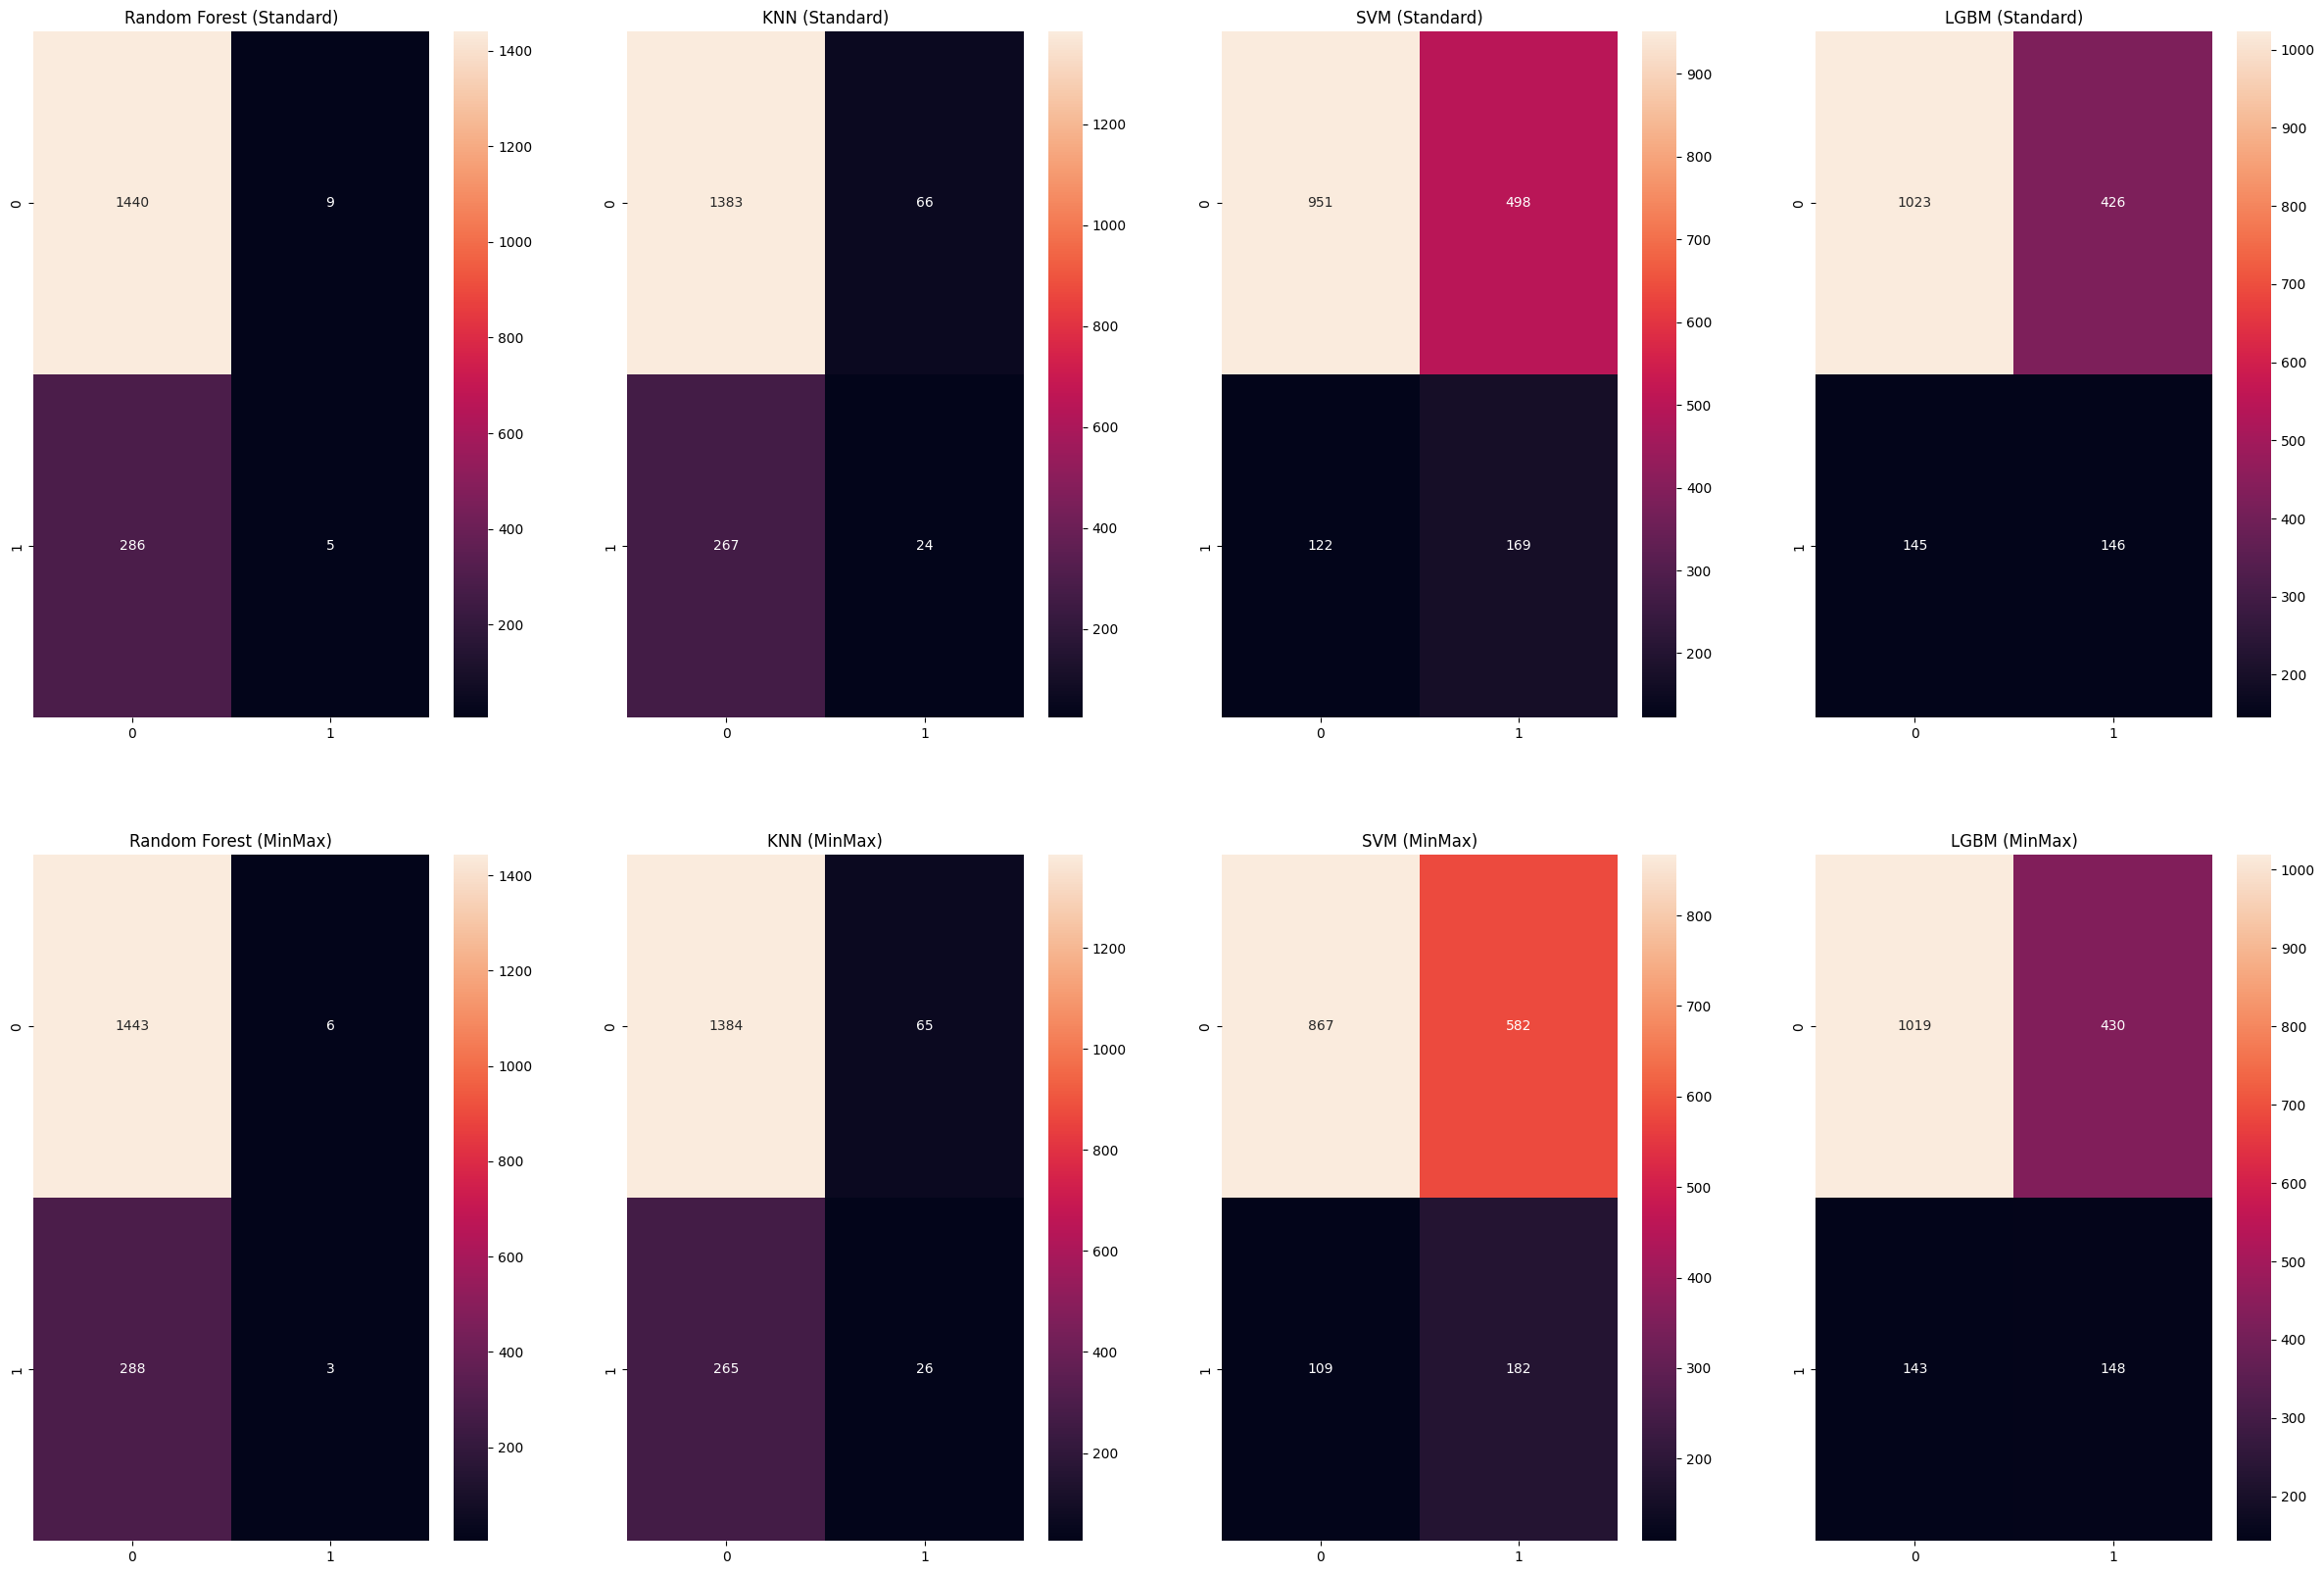

In [26]:
from sklearn.ensemble import IsolationForest

# Isolation Forest

scaler = MinMaxScaler()
df_normalize = scaler.fit_transform(df)
# Convert the scaled data back to a DataFrame
df_normalize = pd.DataFrame(df_normalize, columns=df.columns)

iso_forest = IsolationForest(contamination=0.13, random_state=42)
outliers_iso = iso_forest.fit_predict(df_normalize)

# print(f"Outliers detected: {(outliers_iso == -1).sum()} / {len(outliers_iso)}")

# Mark outliers (1 = inlier, -1 = outlier)
outliers_iso = (outliers_iso == -1)

# Filter out outliers 
df_no_outliers_iso = df_normalize[~outliers_iso]  # keep only the inliers

# Perform classification on the data without outliers
perform_classification_weighted(df_no_outliers_iso)



Standard Scaler
Random Forest
0.828735632183908
Cross Validation value is  0.8304597701149425
[[1439   10]
 [ 288    3]]
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91      1449
         1.0       0.23      0.01      0.02       291

    accuracy                           0.83      1740
   macro avg       0.53      0.50      0.46      1740
weighted avg       0.73      0.83      0.76      1740

0.5017039835506891
KNN
0.8086206896551724
Cross Validation value is  0.8126436781609195
[[1383   66]
 [ 267   24]]
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      1449
         1.0       0.27      0.08      0.13       291

    accuracy                           0.81      1740
   macro avg       0.55      0.52      0.51      1740
weighted avg       0.74      0.81      0.76      1740

0.5184627862799086
SVM
0.6436781609195402
Cross Validation value is  0.6706896551724137
[[951 498]
 [122 169]]

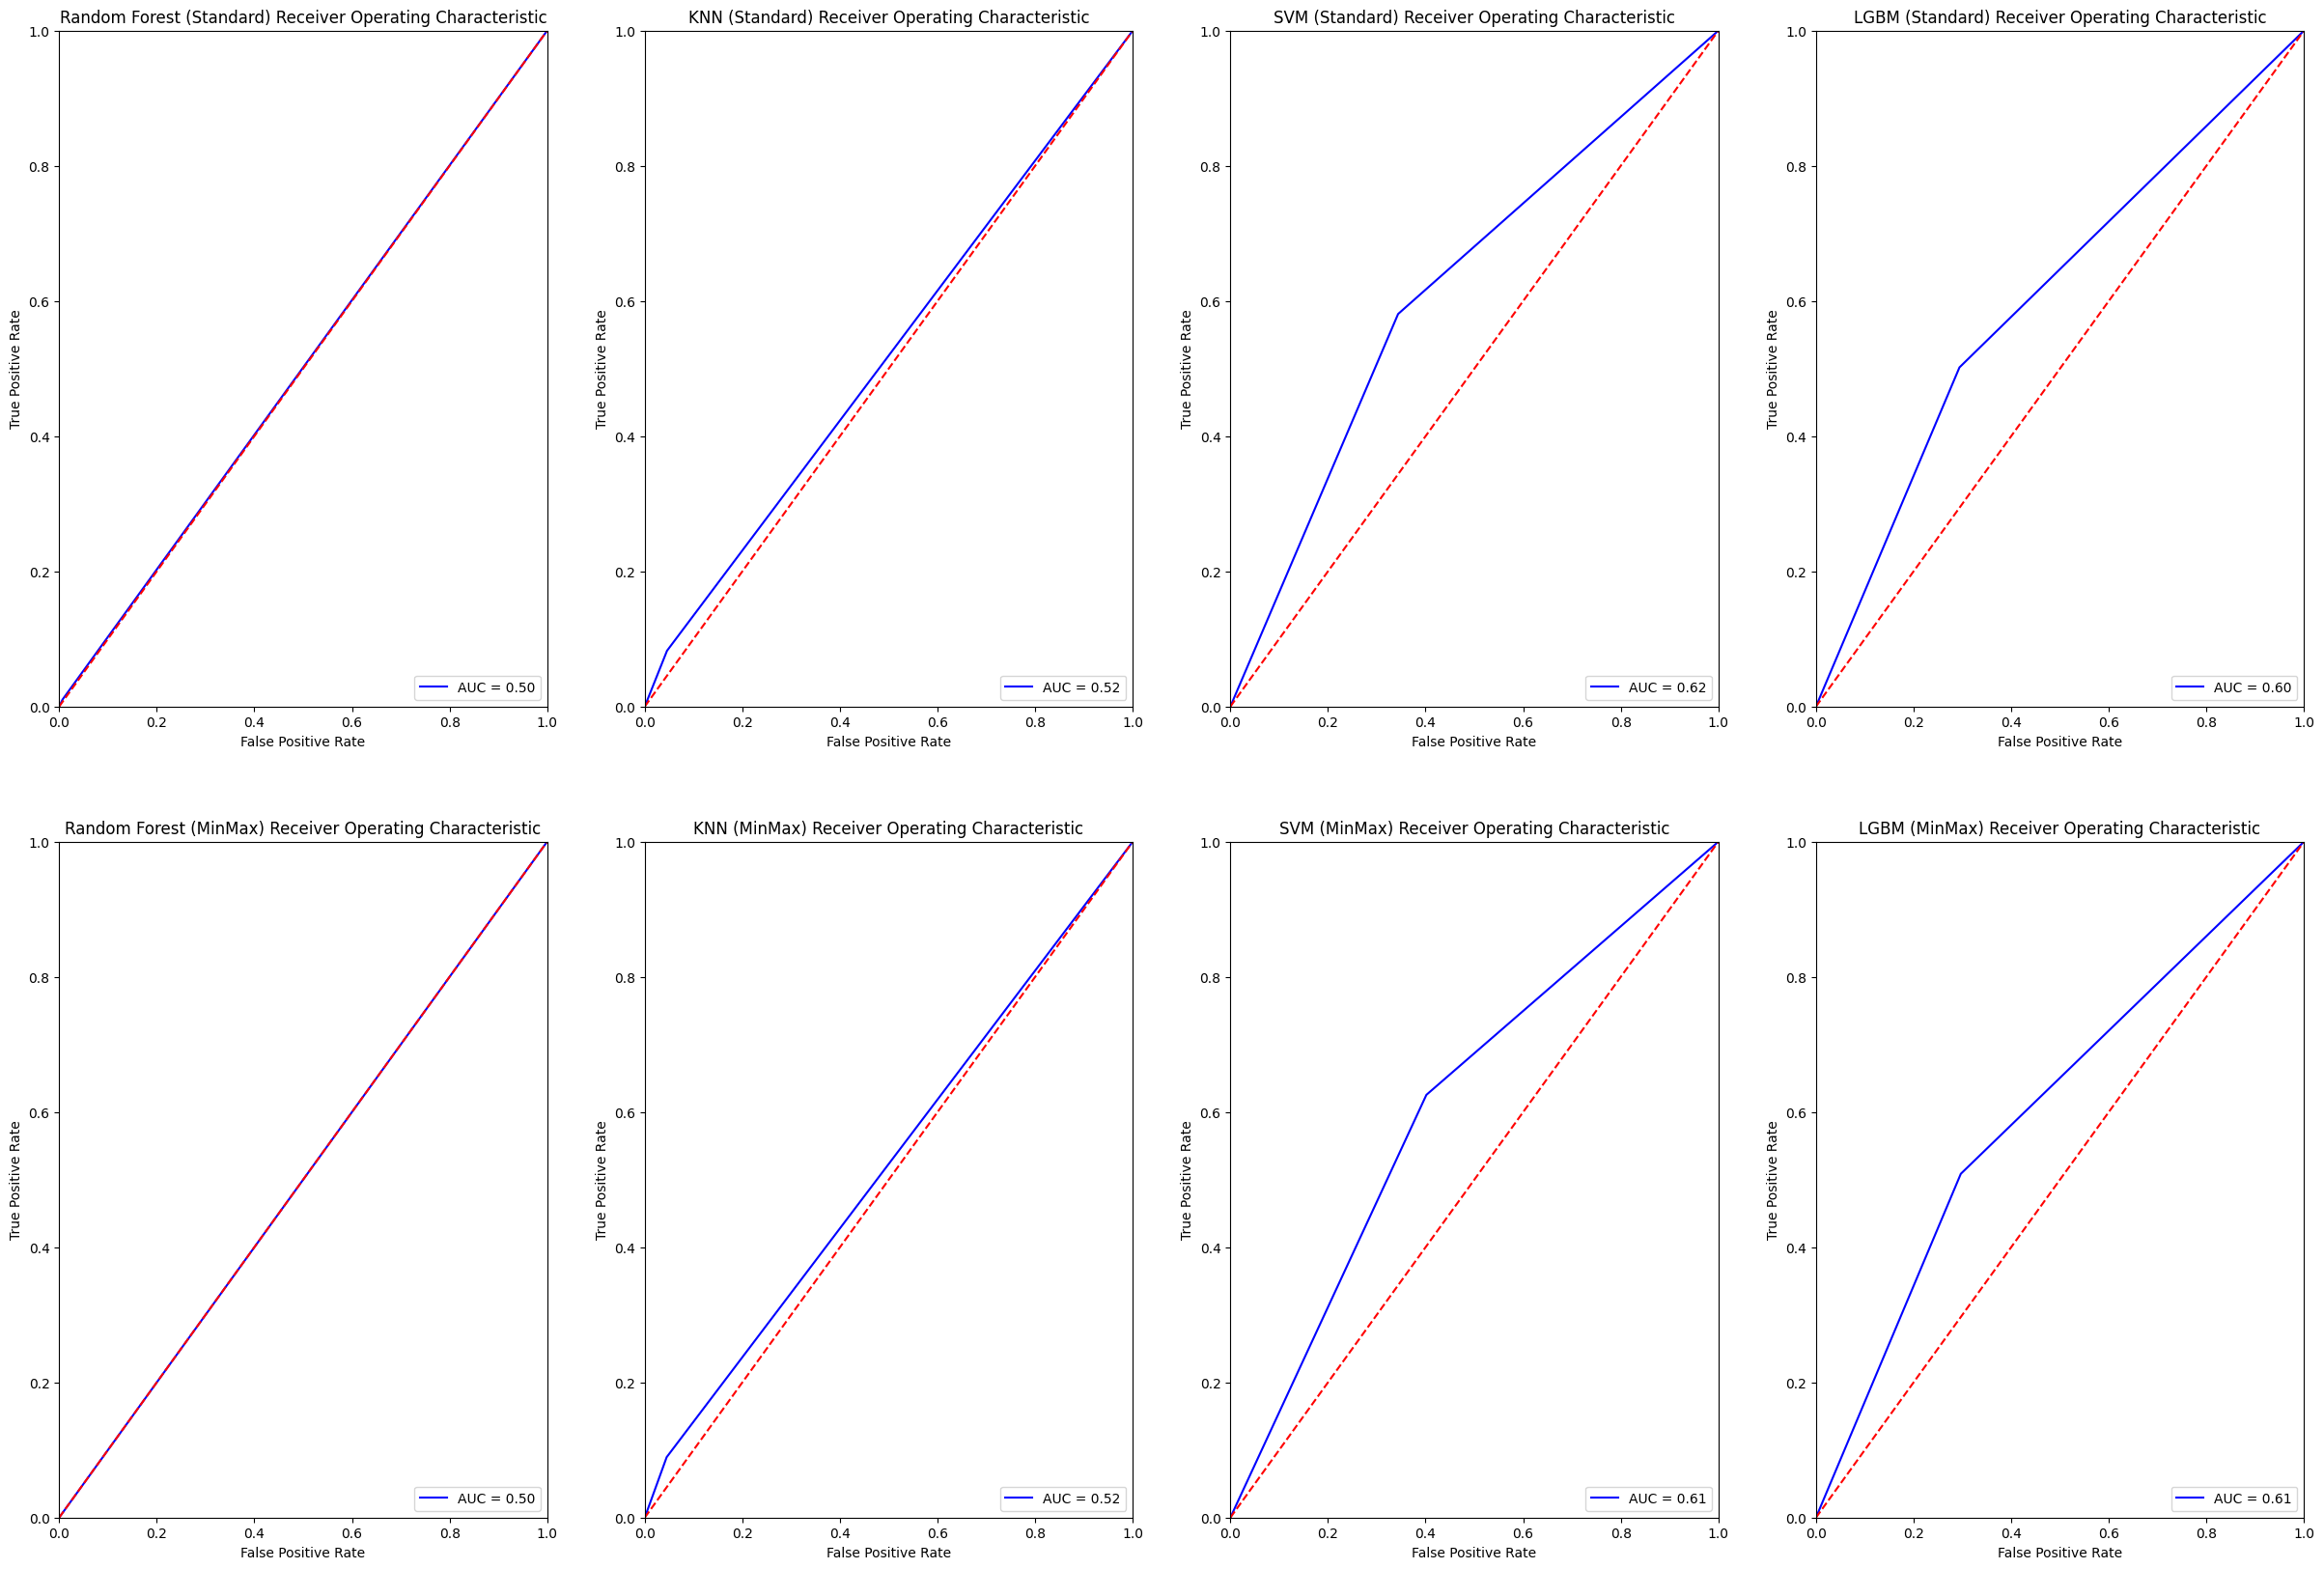

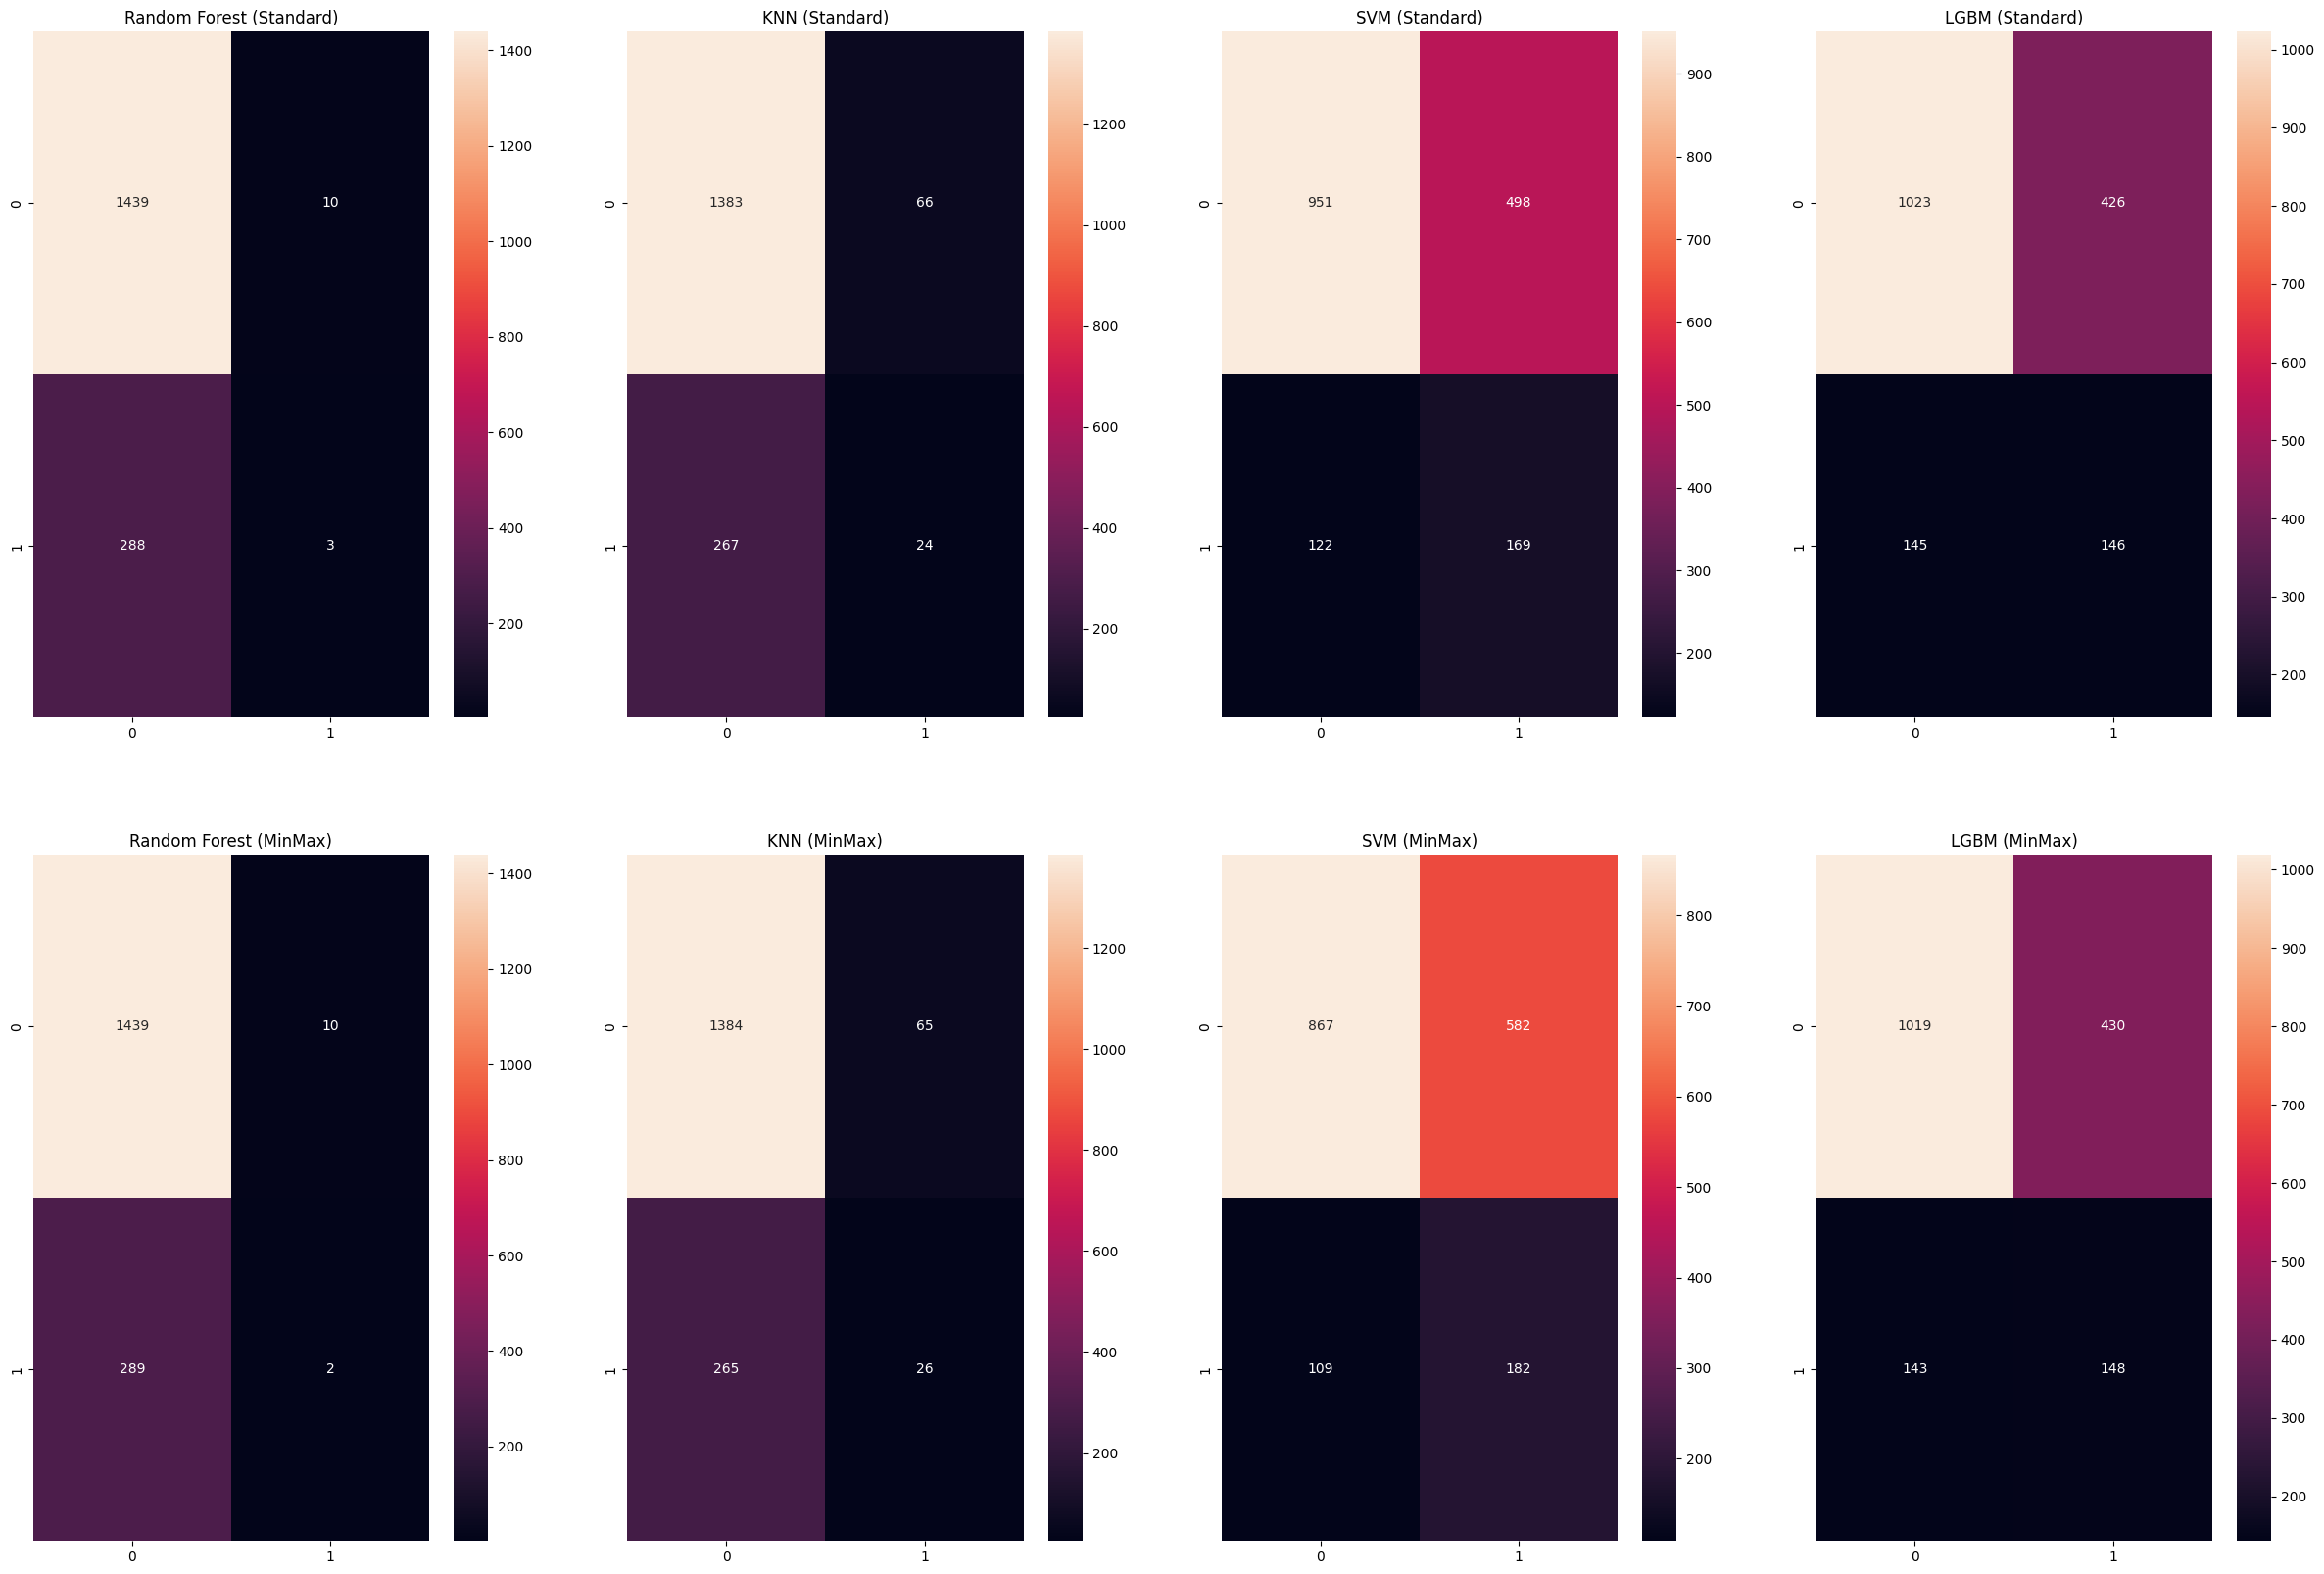

In [23]:
# Perform Outlier Detection and Removal
from sklearn.neighbors import LocalOutlierFactor
def perform_outlier_detection(df):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.13)
    minmax_scalar = MinMaxScaler()
    df_normalize = minmax_scalar.fit_transform(df)

    # Convert the scaled data back to a DataFrame
    df_normalize = pd.DataFrame(df_normalize, columns=df.columns)
        
    outliers_lof = lof.fit_predict(df)

    outliers_lof = (outliers_lof == -1)
    df_no_outliers_lof = df_normalize[~outliers_iso]

    return df_no_outliers_lof

df_no_outliers_lof = perform_outlier_detection(df)

# Perform classification on the data without outliers
perform_classification_weighted(df_no_outliers_lof)

